In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [5]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [6]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [7]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275
...,...
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304


### Lagged Returns 

In [35]:
# Create a lagged return using the shift function
returns['Lagged Returns'] = returns[['Settle']].shift()
returns = returns.rename(columns={'Settle':'Returns'})
returns = returns.dropna()
returns

/var/folders/r6/ccn0zhyx40g2f3y2s1050rl00000gp/T/ipykernel_58968/3156885923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['Lagged Returns'] = returns[['Settle']].shift()


,Returns,Lagged Returns
Date,,
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275
1990-01-11,0.087121,-0.404917
...,...,...
2019-10-09,-0.410601,0.170931
2019-10-10,-0.369458,-0.410601
2019-10-11,-0.564304,-0.369458


### Train Test Split

In [36]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = returns[:'2017']
test = returns['2018':]

In [38]:
# Create 4 dataframes:
#X_train (training set using just the independent variables)
#X_test (test set of of just the independent variables)
#Y_train (training set using just the "y" variable, i.e., "Futures Return")
#Y_test (test set of just the "y" variable):
X_train = train["Lagged Returns"].to_frame()
X_test = test["Lagged Returns"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

In [39]:
X_train

,Lagged Returns
Date,
1990-01-05,1.756933
1990-01-08,-0.827626
1990-01-09,0.129496
1990-01-10,-0.632275
1990-01-11,-0.404917
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [40]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [65]:
# Make a prediction of "y" values using just the test dataset
y_predict = model.predict(X_test)

In [66]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Returns"] = y_predict

In [67]:
Results.head()

,Returns,Predicted Returns
Date,,
2018-01-02,0.297285,0.003503
2018-01-03,-0.240479,0.002713
2018-01-04,-0.213028,0.008581
2018-01-05,-0.353933,0.008282
2018-01-08,0.062017,0.009819


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

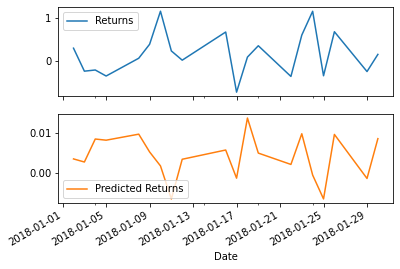

In [51]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [70]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Returns"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"The out-of-sample mean squared error is {mse}")
print(f"The out-of-sample root mean squared error is {rmse}")

The out-of-sample mean squared error is 0.1711035154944656
The out-of-sample root mean squared error is 0.4136466070143276


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [69]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_rmse = np.sqrt(in_sample_mse)
print(f"The in-sample mean squared error is {in_mse}")
print(f"The in-sample root mean squared error is {in_rmse}")

The in-sample mean squared error is 0.49798285800894604
The in-sample root mean squared error is 0.7056790049370507


# Conclusions

After evaluating both the out-of-sample and in-sample models, the out-of-sample model is more accurate because its mean squared error is 0.17 and its root mean squared error is 0.41, while the in-sample's mean squared error is 0.50 and its root mean squared error is 0.71. This makes sense because the in-sample data was the training data in the model, so the out-of-sample model used 27 years of data to build its predictions.